<a href="https://colab.research.google.com/github/jacquesbilombe/CRM-Customers-Churn/blob/main/ChurnScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset for this project can be found on the project's GitHub repository or at [Kaggle](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers/data). This project serves as a case study for the Data Science and Analytics course at PUC RIO. For more information, please refer to the project README.

In [40]:
import os
import csv
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from collections import Counter
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

## Other configurations

In [20]:
%matplotlib inline
warnings.filterwarnings('ignore')

# Clone the project's repository to get the data access
! git clone https://github.com/jacquesbilombe/CRM-Customers-Churn.git

# Set the csv format
pd.options.display.float_format = '{:.2f}'.format

# Set the Graphic hexdecimal color
colors = ['#E94B5C','#87CEEB']

fatal: destination path 'CRM-Customers-Churn' already exists and is not an empty directory.


## Data Exploration

In [34]:
# Files path
data_folder = os.path.join('CRM-Customers-Churn', 'dataset')
DT = pd.read_csv(data_folder + '/' + 'churn.csv').drop(['RowNumber'],axis=1)
# Make a copy of the original Dataset
df = DT.copy(deep = True)
df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [18]:
# Get a general view of all statistic metrics of the dataset
def summary_data(df, head=5):
    func = {
        "Info": df.info(),
        "Shape": df.shape,
        "Mode": df.mode(numeric_only=True),
        # Only for numeric columns
        "Median": df.median(numeric_only=True),
        "Describe": df.describe().T
    }

    for n, f in func.items():
        print("\n################### ", n, " ###################\n")
        if isinstance(f, pd.DataFrame) or isinstance(f, pd.Series):
            print(f)
        else:
            print(f)

summary_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB

###################  Info  ###################

None

###################  Shape  ###################

(10000, 13)

################### 

- It seems that the dataset doesn't have null value
- For the Churn Score problem, the main issue is to know if the customer has exited or not. With standard deviation of `0.4` might suggest that customer churn is a relatively common occurrence in your dataset. However, further analysis is needed to understand the underlying reasons for churn and identify potential areas for improvement.

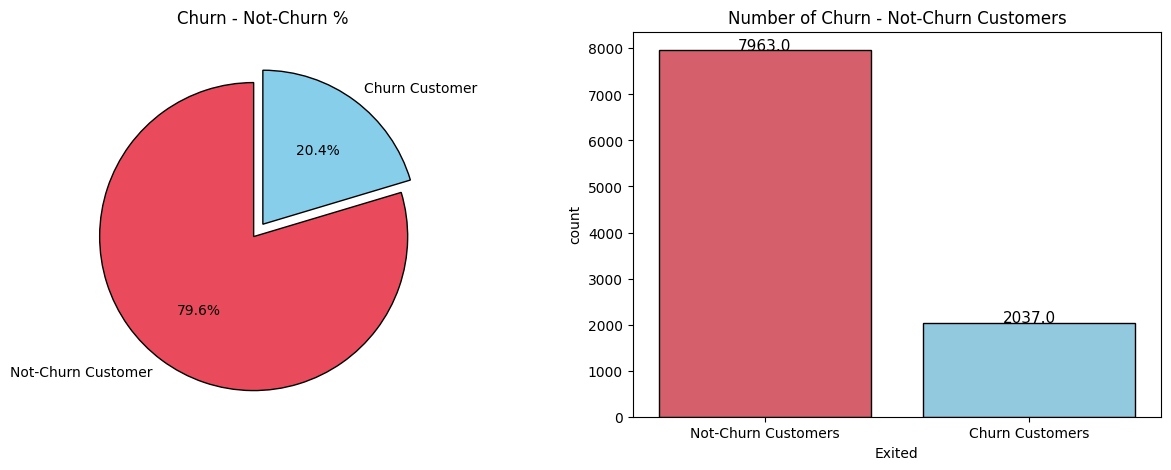

In [22]:
# Get the value counts of the 'Exited' column from the DataFrame and convert to a list
l = list(df['Exited'].value_counts())

# Calculate the percentage of Not-Churn and Churn customers
circle = [l[0] / sum(l) * 100, l[1] / sum(l) * 100]

# Create a pie plot
fig = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# First subplot: Pie chart showing the percentage of Not-Churn and Churn customers
plt.subplot(1, 2, 1)
plt.pie(circle,
        labels=['Not-Churn Customer', 'Churn Customer'],
        autopct='%1.1f%%',
        startangle=90,
        explode=(0.1, 0),
        colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})  # Style the wedges

plt.title('Churn - Not-Churn %');

# Second subplot: Count plot showing the number of Not-Churn and Churn customers
plt.subplot(1, 2, 2)
ax = sns.countplot(x='Exited', data=df, palette=colors, edgecolor='black')

# Annotate each bar with the count value
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2,
            rect.get_height(), horizontalalignment='center', fontsize=11)

# Set x-axis labels for the count plot
ax.set_xticklabels(['Not-Churn Customers', 'Churn Customers'])

plt.title('Number of Churn - Not-Churn Customers');


plt.show()


The above plot provides a clear visualization of customer churn data, allowing us to draw several conclusions:

1. Churn Rate:

  - 20.4% of customers churned: This indicates that a significant portion of the customer base is leaving the company.
  - 79.6% of customers remained: While the churn rate is relatively high, a majority of customers are staying with the company.
2. Distribution:

  - Uneven distribution: The number of churned customers is significantly lower than the number of non-churned customers. This suggests that there might be a significant imbalance in the data, which could affect the accuracy of any churn prediction model.
3. Potential Areas for Improvement:

  - Customer retention: The high churn rate indicates a need for improved customer retention strategies. The company should investigate the reasons for customer churn and take steps to address them.
  - Data balance: If building a machine learning model to predict churn, it might be necessary to address the class imbalance to ensure the model is accurate. Techniques like oversampling or undersampling can be used.

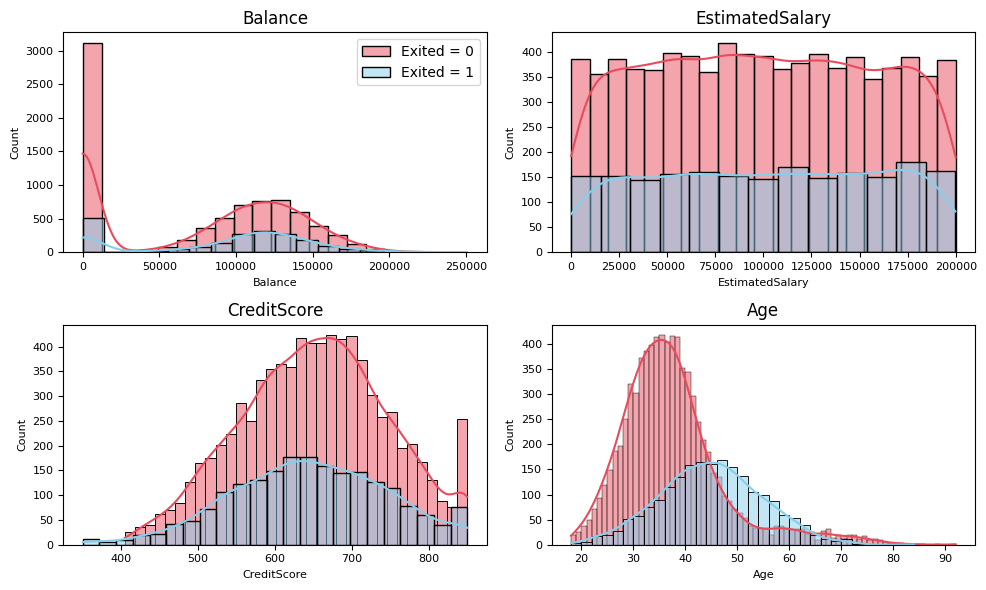

In [28]:
# Exploring the distribution differences between exited and not exited customers for numerical features

numerical_features = df[['Balance', 'EstimatedSalary', 'CreditScore', 'Age', 'Exited']].copy()

exit_values = numerical_features['Exited'].unique()

# Set the color palette for the plots
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(10, 6))

# Loop through each numerical feature except the last one ('Exited')
for i, feature in enumerate(numerical_features.columns[:-1]):
    # Create a subplot for each feature
    plt.subplot(2, 2, i + 1)

    # Plot the histogram for Not Exited customers (Exited = 0) with kernel density estimation (KDE)
    sns.histplot(data=numerical_features[numerical_features['Exited'] == 0],
                 x=feature, kde=True, label='Exited = 0', color=colors[0])

    # Plot the histogram for Exited customers (Exited = 1) with KDE
    sns.histplot(data=numerical_features[numerical_features['Exited'] == 1],
                 x=feature, kde=True, label='Exited = 1', color=colors[1])
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel('Count', fontsize=8)

    # Adjust tick parameters for better readability
    plt.tick_params(axis='both', labelsize=8)

    # Hide the legend for all but the first subplot
    if i > 0:
        plt.legend().set_visible(False)
    else:
        plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()


The visualization provides a comprehensive view of the distributions of several key features (Balance, EstimatedSalary, CreditScore, and Age) and their relationship with the "Exited" variable.

`Key Observations:`

1. Balance:
  - The distribution of "Balance" is skewed to the right, indicating that a majority of customers have lower balances.
  - There is a slight overlap between the distributions for "Exited" and "Not Exited" customers. This suggests that balance alone may not be a strong predictor of churn.
2. EstimatedSalary:
  - The distribution of "EstimatedSalary" is also skewed to the right.
  - There is a slight overlap between the distributions for "Exited" and "Not Exited" customers, but the overlap is less pronounced than with "Balance."
3. CreditScore:
  - The distribution of "CreditScore" appears relatively normal, with a slight skew to the right.
  - There is a clear separation between the distributions for "Exited" and "Not Exited" customers. Customers with lower credit scores are more likely to churn.
4. Age:
  - The distribution of "Age" is skewed to the right, indicating that most customers are relatively young.
  - There is a slight overlap between the distributions for "Exited" and "Not Exited" customers, but the overlap is less pronounced than with "Balance" and "EstimatedSalary."

`Conclusion:`

  - The visualization provides valuable insights into the relationship between customer churn and various features. Based on the observations, "CreditScore" appears to be a promising predictor of churn. Further analysis is needed to build a more comprehensive understanding of the factors influencing customer churn and develop effective retention strategies.

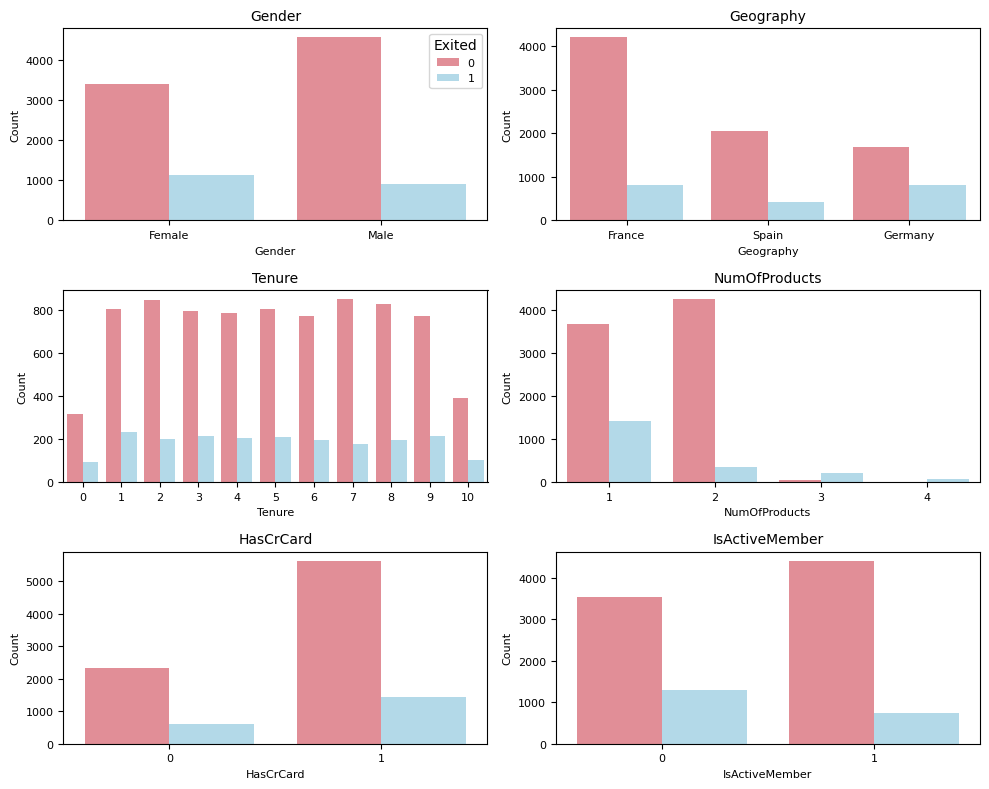

In [29]:
# Exploring the distribution differences between exited and not exited customers for categorical features

# Select relevant categorical features and create a copy
categorical_features = df[['Gender', 'Geography', 'Tenure',
                           'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']]

sns.set_palette("deep")

plt.figure(figsize=(10, 8))

# Loop through each categorical feature except the last one ('Exited')
for i, feature in enumerate(categorical_features.columns[:-1]):
    # Create a subplot for each feature
    plt.subplot(3, 2, i + 1)

    # Create a count plot for the categorical feature, colored by 'Exited' status
    sns.countplot(data=categorical_features, x=feature, hue='Exited',
                  alpha=0.7, palette=[colors[0], colors[1]])

    # Set the title, x-label, and y-label for the subplot
    plt.title(f'{feature}', fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel('Count', fontsize=8)

    plt.tick_params(axis='both', labelsize=8)
    if i > 0:
        plt.legend().set_visible(False)
    else:
        plt.legend(title='Exited', fontsize=8)

plt.tight_layout()

# Display the plots
plt.show()


The visualization provides a comprehensive view of the distribution of Gender, Geography, Tenure, NumOfProducts, HasCrCard, IsActiveMember features and their relationship with the "Exited" variable.

`Key Observations:`

1. Gender: The distribution of "Gender" is slightly skewed towards female customers. There is a notable difference in churn rates between genders, with male customers having a higher propensity to churn.

2. Geography: The distribution of "Geography" shows that France has the highest number of customers, followed by Spain and Germany. There are differences in churn rates across geographies, with Spain having the highest churn rate.

3. Tenure: The distribution of "Tenure" shows that most customers have been with the bank for less than 5 years. There is a slight increase in churn among customers with longer tenures.

4. NumOfProducts: The distribution of "NumOfProducts" shows that most customers have 1 or 2 products. There is a slight decrease in churn among customers with more products.

5. HasCrCard: The distribution of "HasCrCard" shows that a majority of customers have a credit card. There is no significant difference in churn rates between customers with and without credit cards.

6. IsActiveMember: The distribution of "IsActiveMember" shows that a majority of customers are active members. There is a significant difference in churn rates between active and inactive members, with inactive members being more likely to churn.

## Pre processing

### Data Scalling

- Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.

  Eg : Age = Years; Balance = Amounts

- We have 2 options for data scaling : `Normalization` and `Standardization`. As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.

- Normalization : Age, Balance, CreditScore and EstimatedSalary features are normalized as they displayed a right skewed and bimodal data distribution.

- Standardization : None of the features are standardized for the above data.

In [35]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Selecting numerical columns for scaling
numerical_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

df = df.drop(['CustomerId','Surname'],axis=1)
# Fit and transform the selected numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.54,France,Female,0.32,2,0.00,1,1,1,0.51,1
1,0.52,Spain,Female,0.31,1,0.33,1,0,1,0.56,0
2,0.30,France,Female,0.32,8,0.64,3,1,0,0.57,1
3,0.70,France,Female,0.28,1,0.00,2,0,0,0.47,0
4,1.00,Spain,Female,0.34,2,0.50,1,1,1,0.40,0


### One Hot Encoding

In [36]:
# Variables to apply one hot encoding
lista = ["Gender", "Geography"]
df = pd.get_dummies(df, columns =lista, drop_first = True)
df.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
9995,0.84,0.28,5,0.00,2,1,0,0.48,0,True,False,False
9996,0.33,0.23,10,0.23,1,1,1,0.51,0,True,False,False
9997,0.72,0.24,7,0.00,1,0,1,0.21,1,False,False,False
9998,0.84,0.32,3,0.30,2,1,0,0.46,1,True,True,False
9999,0.88,0.14,4,0.52,1,1,0,0.19,0,False,False,False


#### Correlation Matrix

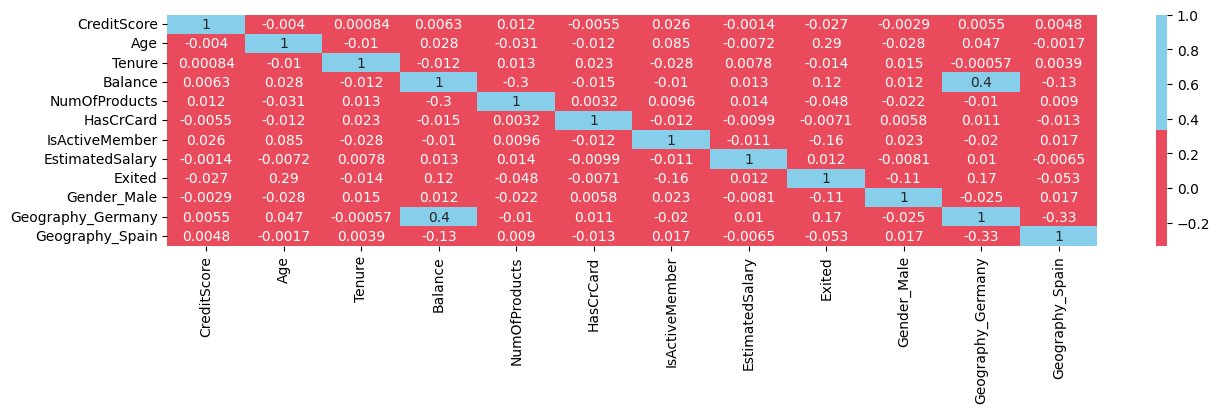

In [37]:
plt.figure(figsize = (15,3))
sns.heatmap(df.corr(),cmap = colors,annot = True);

### Data Balancing using SMOTE

As seem during the data exploration, our dataset isn't balaced.
With 76.6% of data as **No Churned Costumer** and 20.4% as **Churned**.
We'll try to balance the dataset for a good result during Modeling.

In [39]:
# Move the "Exited" column at the last position
cols = df.columns.tolist()
cols.remove('Exited')
cols.append('Exited')
df = df[cols]
df.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,Exited
0,0.54,0.32,2,0.00,1,1,1,0.51,False,False,False,1
1,0.52,0.31,1,0.33,1,0,1,0.56,False,False,True,0
2,0.30,0.32,8,0.64,3,1,0,0.57,False,False,False,1
3,0.70,0.28,1,0.00,2,0,0,0.47,False,False,False,0
4,1.00,0.34,2,0.50,1,1,1,0.40,False,False,True,0


In [41]:
over = SMOTE(sampling_strategy = 1)

X = df.drop("Exited",axis=1)
y = df["Exited"]

X, y = over.fit_resample(X, y)

In [44]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
0,0.54,0.32,2,0.00,1,1,1,0.51,False,False,False
1,0.52,0.31,1,0.33,1,0,1,0.56,False,False,True
2,0.30,0.32,8,0.64,3,1,0,0.57,False,False,False
3,0.70,0.28,1,0.00,2,0,0,0.47,False,False,False
4,1.00,0.34,2,0.50,1,1,1,0.40,False,False,True


In [43]:
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


## Next Steps:

- Feature selection using `SelectKBest`method for **Categorical Features** and `ANOVA Score` for **Numerical Features.**
- Modeling; before everything, you'll have ti split the training and testing dataset to `fit` the model. Here ab example for this **Notebook**:

```python
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True, random_state = 42, stratify=y)
